<a href="https://colab.research.google.com/github/kundajelab/locusselect/blob/master/examples/regression%20on%20200%20bp%20genome%20bins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from numpy.random import seed
seed(1234)
import pandas as pd 

In [2]:
#!pip install locusselect 

## H1ESC ATAC bpnet model, global average pooll, 500 filters 

In [3]:
## generate embeddings at the -2 layer 
import locusselect 
from locusselect.embeddings import * 
from locusselect.interpret import * 
from locusselect.utils import * 
from locusselect.gapped_kmers import * 
import numpy as np


Using TensorFlow backend.


In [5]:
#get embeddings for all overlap peaks 
splits=list(range(10))
coord_prefix="/mnt/lab_data2/annashch/locusselect_applications/splits/h1esc_atac_overlap/h1esc.atac.optimal_peak.narrowPeak"
model_prefix="/srv/scratch/annashch/deeplearning/profile/h1esc_atac/baseline/h1esc.atac.seed.1234.cs.56.filters.500.naive.range.4.6.to.11.5"
embedding_layer_name="gap"
embedding_input_name="sequence"
'''
for split in splits: 
    fc_embedding_args={"input_bed_file":coord_prefix+"."+str(split),
                "model_hdf5":model_prefix+"."+str(0)+".hdf5",
                "ref_fasta":"/users/annashch/male.hg19.fa",
                "center_on_summit":True,
                "center_on_bed_interval":False,
                "flank":673,
                "batch_size":20,
                "embedding_layer_name":embedding_layer_name,
                "embedding_input_name":embedding_input_name,
                "expand_dims":False,
                "threads":20,
                "output_npz_file":str(split)+".H1ESC.ATAC.all_peaks.bpnet.npz"}
    fc_regions, fc_embeddings = compute_embeddings(fc_embedding_args)
'''

'\nfor split in splits: \n    fc_embedding_args={"input_bed_file":coord_prefix+"."+str(split),\n                "model_hdf5":model_prefix+"."+str(0)+".hdf5",\n                "ref_fasta":"/users/annashch/male.hg19.fa",\n                "center_on_summit":True,\n                "center_on_bed_interval":False,\n                "flank":673,\n                "batch_size":20,\n                "embedding_layer_name":embedding_layer_name,\n                "embedding_input_name":embedding_input_name,\n                "expand_dims":False,\n                "threads":20,\n                "output_npz_file":str(split)+".H1ESC.ATAC.all_peaks.bpnet.npz"}\n    fc_regions, fc_embeddings = compute_embeddings(fc_embedding_args)\n'

In [8]:
## get the loci embeddings 
coord_prefix="/mnt/lab_data2/annashch/locusselect_applications/coordinates/H1ESC_PROXY_FOR_WTC11/"
loci_df=pd.read_csv("/mnt/lab_data2/annashch/locusselect_applications/coordinates/H1ESC_PROXY_FOR_WTC11/gene_to_fold.geneLocus.250bp.windows.hg19.bed",header=None,sep='\t')
'''
for index,row in loci_df.iterrows(): 
    locus=row[0] 
    split=row[1]
    coords=coord_prefix+locus+".geneLocus.250bp.windows.hg19.bed"
    #first, we get embeddings from the model fully connected layer 
    fc_embedding_args={"input_bed_file":coords,
                   "model_hdf5":model_prefix+"."+str(0)+".hdf5",
                   "ref_fasta":"/users/annashch/male.hg19.fa",
                   "center_on_summit":True,
                   "center_on_bed_interval":False,
                   "flank":673,
                   "embedding_layer_name":embedding_layer_name,
                   "embedding_input_name":embedding_input_name,
                   "expand_dims":False,
                   "threads":20,
                   "batch_size":20,
                   "output_npz_file":locus+".H1ESC.ATAC.locus.bpnet.npz"}
    fc_regions, fc_embeddings = compute_embeddings(fc_embedding_args)
'''

'\nfor index,row in loci_df.iterrows(): \n    locus=row[0] \n    split=row[1]\n    coords=coord_prefix+locus+".geneLocus.250bp.windows.hg19.bed"\n    #first, we get embeddings from the model fully connected layer \n    fc_embedding_args={"input_bed_file":coords,\n                   "model_hdf5":model_prefix+"."+str(0)+".hdf5",\n                   "ref_fasta":"/users/annashch/male.hg19.fa",\n                   "center_on_summit":True,\n                   "center_on_bed_interval":False,\n                   "flank":673,\n                   "embedding_layer_name":embedding_layer_name,\n                   "embedding_input_name":embedding_input_name,\n                   "expand_dims":False,\n                   "threads":20,\n                   "batch_size":20,\n                   "output_npz_file":locus+".H1ESC.ATAC.locus.bpnet.npz"}\n    fc_regions, fc_embeddings = compute_embeddings(fc_embedding_args)\n'

In [9]:
#combine the loci embeddings into a single data frame 
all_embeddings=None
all_bed_entries=None
locus_to_pos={}
locus_suffix=".H1ESC.ATAC.locus.bpnet.npz"
loci=list(loci_df[0])

last_index=0
for locus in loci: 
    cur_embedding_data=np.load(locus+locus_suffix,allow_pickle=True)
    cur_bed_entries=cur_embedding_data['bed_entries']
    cur_embeddings=cur_embedding_data['embeddings']
    if all_embeddings is None: 
        all_embeddings=cur_embeddings 
        all_bed_entries=cur_bed_entries
    else: 
        all_embeddings=np.concatenate((all_embeddings,cur_embeddings),axis=0)
        all_bed_entries=np.concatenate((all_bed_entries,cur_bed_entries),axis=0)
    start_pos=last_index 
    end_pos=last_index+cur_embeddings.shape[0]
    last_index=end_pos 
    locus_to_pos[locus]=[start_pos,end_pos]


In [10]:
all_embeddings.shape

(675308, 500)

In [11]:
#augment with all peak embeddings 
splits=list(range(10))

for split in splits: 
    cur_embeddings_data=np.load(str(split)+".H1ESC.ATAC.all_peaks.bpnet.npz",allow_pickle=True)
    cur_bed_entries=cur_embedding_data['bed_entries']
    cur_embeddings=cur_embedding_data['embeddings']
    all_embeddings=np.concatenate((all_embeddings,cur_embeddings),axis=0)
    all_bed_entries=np.concatenate((all_bed_entries,cur_bed_entries),axis=0)

In [12]:
all_bed_entries.shape

(755308,)

In [13]:
all_embeddings.shape

(755308, 500)

In [14]:
# run PCA on the embeddings 
# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score


In [15]:
from sklearn.decomposition import PCA 
  
pca = PCA(n_components = 500) 
  
pca_res = pca.fit_transform(all_embeddings)   
explained_variance = pca.explained_variance_ratio_ # verify that the PCA embeddings have same UMAP projection as original embeddings. 

In [16]:
explained_variance[0:10]
np.cumsum(explained_variance)

array([0.51649087, 0.79474425, 0.85772828, 0.90691117, 0.92707418,
       0.94201011, 0.95110245, 0.95836084, 0.9642039 , 0.96850653,
       0.97175559, 0.9739176 , 0.97568556, 0.97723223, 0.9787094 ,
       0.97997886, 0.98102382, 0.98182721, 0.98256495, 0.98324555,
       0.98383993, 0.98439715, 0.98494032, 0.98545036, 0.98591483,
       0.98632665, 0.98672445, 0.98706799, 0.9874073 , 0.98771633,
       0.98800558, 0.98829089, 0.98856416, 0.98882405, 0.98905871,
       0.98927748, 0.98947954, 0.98967792, 0.98987006, 0.9900564 ,
       0.99023526, 0.99040579, 0.99057133, 0.99073272, 0.99088824,
       0.99103569, 0.99117904, 0.99131852, 0.99145726, 0.99158547,
       0.99171226, 0.99183662, 0.99195832, 0.99207695, 0.99219104,
       0.99230365, 0.99240963, 0.99251308, 0.99261587, 0.99271508,
       0.99281074, 0.99290384, 0.99299489, 0.99308447, 0.99317283,
       0.99325623, 0.99333754, 0.99341807, 0.99349631, 0.99357232,
       0.99364656, 0.99371921, 0.99378985, 0.99386014, 0.99392

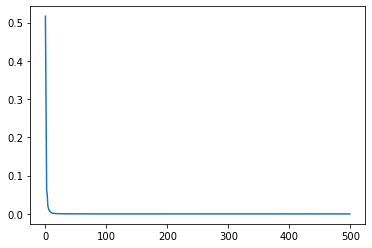

In [17]:
from matplotlib import pyplot as plt
plt.plot(explained_variance)

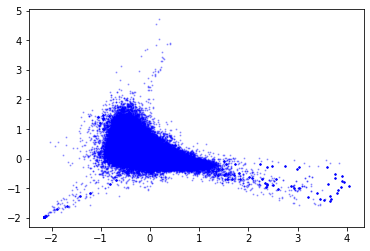

In [18]:
plt.plot(pca_res[:,0],pca_res[:,1],'bo',markersize=1,alpha=0.3)


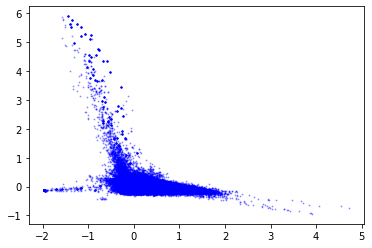

In [19]:
plt.plot(pca_res[:,1],pca_res[:,2],'bo',markersize=1,alpha=0.3)


In [20]:
from plotnine import * 

## We subset to 40 pc's 

In [21]:
loci[0]

'OPRD1'

In [ ]:
for locus in loci: 
    gc_content=open("/mnt/lab_data2/annashch/locusselect_applications/compute_gc/gc."+locus+".bed",'r').read().strip().split('\n')
    gc_vals=np.expand_dims(np.asarray([float(i.split('\t')[-1]) for i in gc_content]),axis=1)
    #add gc column to embedding 
    pca_with_gc=np.concatenate((pca_res[locus_to_pos[locus][0]:locus_to_pos[locus][1],0:40],gc_vals),axis=1)
    coords=all_bed_entries[locus_to_pos[locus][0]:locus_to_pos[locus][1]]
    print(pca_with_gc.shape)
    #save 
    np.savez_compressed(locus+".H1ESC.ATAC.locus.bpnet.top40pcs.npz",bed_entries=coords,embeddings=pca_with_gc)
    
    pca_2d = umap.UMAP(random_state=42).fit_transform(pca_with_gc)
    df_pca=pd.DataFrame.from_dict({'pca_2d_1':pca_2d[:,0],
                              'pca_2d_2':pca_2d[:,1],
                              'gc':gc_vals.squeeze()})
    (ggplot(df_pca,aes(x='pca_2d_1', y='pca_2d_2',color='gc'))+
       geom_point(size=1,alpha=0.3)+
       ggtitle(locus+",BPNET, Global Ave. Pool, H1ESC, DNASE, 40 PCs")).save(filename=locus+".H1ESC.ATAC.locus.bpnet.top40pcs.png",width=3,height=3,units='in',dpi=60)
    
    un_corrected_fc_embeddings_2d = umap.UMAP(random_state=42).fit_transform(all_embeddings[locus_to_pos[locus][0]:locus_to_pos[locus][1]])

    df_fc=pd.DataFrame.from_dict({'un_corrected_fc_1':un_corrected_fc_embeddings_2d[:,0],
                              'un_corrected_fc_2':un_corrected_fc_embeddings_2d[:,1],
                              'gc':gc_vals.squeeze()})
    (ggplot(df_fc,aes(x='un_corrected_fc_1', y='un_corrected_fc_2',color='gc'))+
       geom_point(size=1,alpha=0.3)+
       ggtitle(locus+", BPNET, Global Ave. Pool, H1ESC, DNASE")).save(filename=locus+".H1ESC.ATAC.locus.bpnet.png",width=3,height=3,units='in',dpi=60)


(8000, 41)
(8000, 41)
(8000, 41)


In [ ]:
model

In [ ]:
from kerasAC.custom_losses import *
from kerasAC.metrics import recall, specificity, fpr, fnr, precision, f1
from keras.models import load_model
import pdb
custom_objects={"recall":recall,
                "sensitivity":recall,
                "specificity":specificity,
                "fpr":fpr,
                "fnr":fnr,
                "precision":precision,
                "f1":f1,
                "ambig_binary_crossentropy":ambig_binary_crossentropy,
                "ambig_mean_absolute_error":ambig_mean_absolute_error,
                "ambig_mean_squared_error":ambig_mean_squared_error}
model=load_model(model,custom_objects=custom_objects)


In [ ]:
all_n=np.zeros((1,1,1000,4))
n_gc=np.zeros((1,))

In [ ]:
model.predict([all_n,n_gc])